In [46]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

In [2]:
# Class to print string in bold
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print (device)

cpu


In [4]:
# functions to show an image

def imshow(img, title = False):

    plt.imshow(np.transpose(img, (1, 2, 0)))
    if(title):
        plt.title("{}".format(title))
    plt.show()


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
base_dir = '/content/drive/MyDrive/IE643_Assignment2/Folder_Labelled'
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),
    ]
)
dataset = ImageFolder(base_dir, transform=transformer)

In [7]:
#Only class-5 (class numbering starts from 0,1,2..) is selected. This roughly appears to be sunflower category.

mb_size = 4   #Mini-batch size

def get_indices(dataset, k):
    indices =  []
    sub_data = []
    for i in range(len(dataset.targets)):  #use train_labels if error with tragets 
        if dataset.targets[i] == k :  # or dataset.targets[i] == 4 or dataset.targets[i] == 6:
            indices.append(i)   #indices of data with labels 2, 4 or 6
            sub_data.append(dataset[i])
    return indices, sub_data

idx, sub_data = get_indices(dataset, 5)       #Class-5 is selected for training purpose.
print(len(idx))

from sklearn.model_selection import train_test_split
idx_train, idx_test = train_test_split(idx, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(dataset,batch_size=mb_size, 
                                          sampler = torch.utils.data.sampler.SubsetRandomSampler(idx_train))

80


# VAE Model

In [22]:
class VAE(nn.Module):
    def __init__(self,  image_size = 64, channel_num = 3, kernel_num = 128, z_size = 8):
        # configurations
        super().__init__()
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        self.num_encoder_layers = 2
        
        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 2),

            self._conv(kernel_num // 2, kernel_num)
        )

        # encoded feature's size and volume
        self.feature_size = image_size // (2**self.num_encoder_layers)
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
        self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)

        # projection
        self.project = self._linear(z_size, self.feature_volume, relu=False)

        
        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),

            self._deconv(kernel_num // 2, channel_num),
            
        
            nn.ReLU()
        )

        
    def forward(self, x):
        # encode x
        encoded = self.encoder(x)

        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)
        return (mean, logvar, x_reconstructed)

    # ==============
    # VAE components
    # ==============

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).to(device)
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.MSELoss(size_average=False)(x_reconstructed, x)/ x.size(0)
    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()
    

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num):
        return nn.Sequential(
            nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num):
        return nn.Sequential(
            nn.ConvTranspose2d(
                channel_num, kernel_num,
                kernel_size=4, stride=2, padding=1,
            ),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)



In [51]:
model = VAE().to(device)
optimizer_vae = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# Train Function

In [ ]:
epoch_list=[]
kl_loss_list=[]
rec_loss_list=[]
train_obj_list=[]
epochs = 300
for epoch in range(1, epochs + 1):
    train_loss = 0
    recon_loss = 0
    kl_loss = 0
    recon_batch = None
    for batch_idx, (data, classes) in enumerate(train_loader):
            data, classes = data.to(device), classes.to(device)
            optimizer_vae.zero_grad()
            mu, logvar, recon_batch = model(data)


            reconstruction_loss = model.reconstruction_loss(recon_batch, data)
            kl_divergence_loss = model.kl_divergence_loss(mu, logvar)
            recon_loss += reconstruction_loss.item()
            loss = reconstruction_loss + kl_divergence_loss #+ 100*quantile_loss
            kl_loss += kl_divergence_loss.item()
            loss.backward()
            train_loss += loss.item()
            optimizer_vae.step()
    
    epoch_list.append(epoch)
    kl_loss_list.append(kl_loss / (len(train_loader)*20))
    rec_loss_list.append(recon_loss / (len(train_loader)*20))
    train_obj_list.append(train_loss / (len(train_loader)*20))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average Reconstruction loss: {:.4f}'.format(
        epoch, recon_loss / (len(train_loader)*20)))
    print('====> Epoch: {} Average KL loss: {:.4f}'.format(
        epoch, kl_loss / (len(train_loader)*20)))
    
    if (True):#(epoch % 10 == 0): 
        print(color.BOLD + 'Original Samples:' + color.END)
        imshow(torchvision.utils.make_grid(data.cpu(), padding=2, normalize=True))
        print(color.BOLD + 'Generated Generated:' + color.END)
        imshow(torchvision.utils.make_grid(recon_batch.view(-1,3,64,64).detach().cpu(), padding=2, normalize=True))


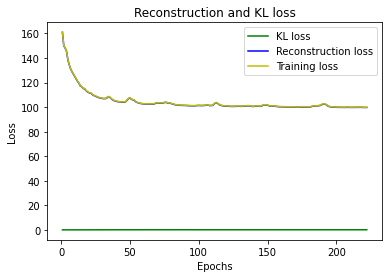

In [58]:
plt.plot(epoch_list, kl_loss_list, 'g', label='KL loss')
plt.plot(epoch_list, rec_loss_list, 'b', label='Reconstruction loss')
plt.plot(epoch_list, train_obj_list, 'y', label='Training loss')
plt.title('Reconstruction and KL loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the process of encoding the input image into a smaller sized vector and further decoding it to reconstruct our initial image, we are trying to project the image into a smaller but meaningful latent space.

In [54]:
z=torch.randn(10, model.z_size)

z_projected = model.project(z).view(-1, model.kernel_num, model.feature_size, model.feature_size)

samples = model.decoder(z_projected).data

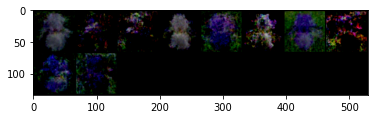

In [55]:
imshow(torchvision.utils.make_grid(samples.view(-1,3,64,64).detach().cpu(), padding=2, normalize=True))

In [56]:
list_0=[]
list_1=[]
list_2=[]
list_3=[]
list_4=[]
list_5=[]
list_6=[]
list_7=[]
list_8=[]
list_9=[]

for i in range(len(sub_data)):
  list_0.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[0]))
  list_1.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[1]))
  list_2.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[2]))
  list_3.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[3]))
  list_4.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[4]))
  list_5.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[5]))
  list_6.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[6]))
  list_7.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[7]))
  list_8.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[8]))
  list_9.append(nn.MSELoss(size_average=True)(sub_data[i][0], samples[9]))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
fig, axs = plt.subplots(10, 6, figsize=(10,10))

for i in range(10):
  axs[i,0].imshow(np.transpose(vutils.make_grid(samples[i], normalize=True).cpu(),(1,2,0)))

for j in range(1,6):
    
    axs[0,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_0))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[1,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_1))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[2,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_2))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[3,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_3))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[4,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_4))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[5,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_5))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[6,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_6))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[7,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_7))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[8,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_8))[j-1]][0], normalize=True).cpu(),(1,2,0)))
    axs[9,j].imshow(np.transpose(vutils.make_grid(sub_data[np.argsort(np.array(list_9))[j-1]][0], normalize=True).cpu(),(1,2,0)))

    axs[i,j].axis('off')